Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


File gp_params.yaml loaded from data/rail/
Building new GP models
Loading mode rail with ['data/rail/1.bag', 'data/rail/2.bag', 'data/rail/3.bag']
Loading ros bag data/rail/1.bag  with 3158 msgs
Loading ros bag data/rail/2.bag  with 6997 msgs
Loading ros bag data/rail/3.bag  with 3767 msgs
Total of 7206 messages after trim

________________________________________
# Optimizing hyperparameters (N=50)
----------------------------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Total number of variables............................:       18
                     variables with only lower bounds:        0
                variables with lower and

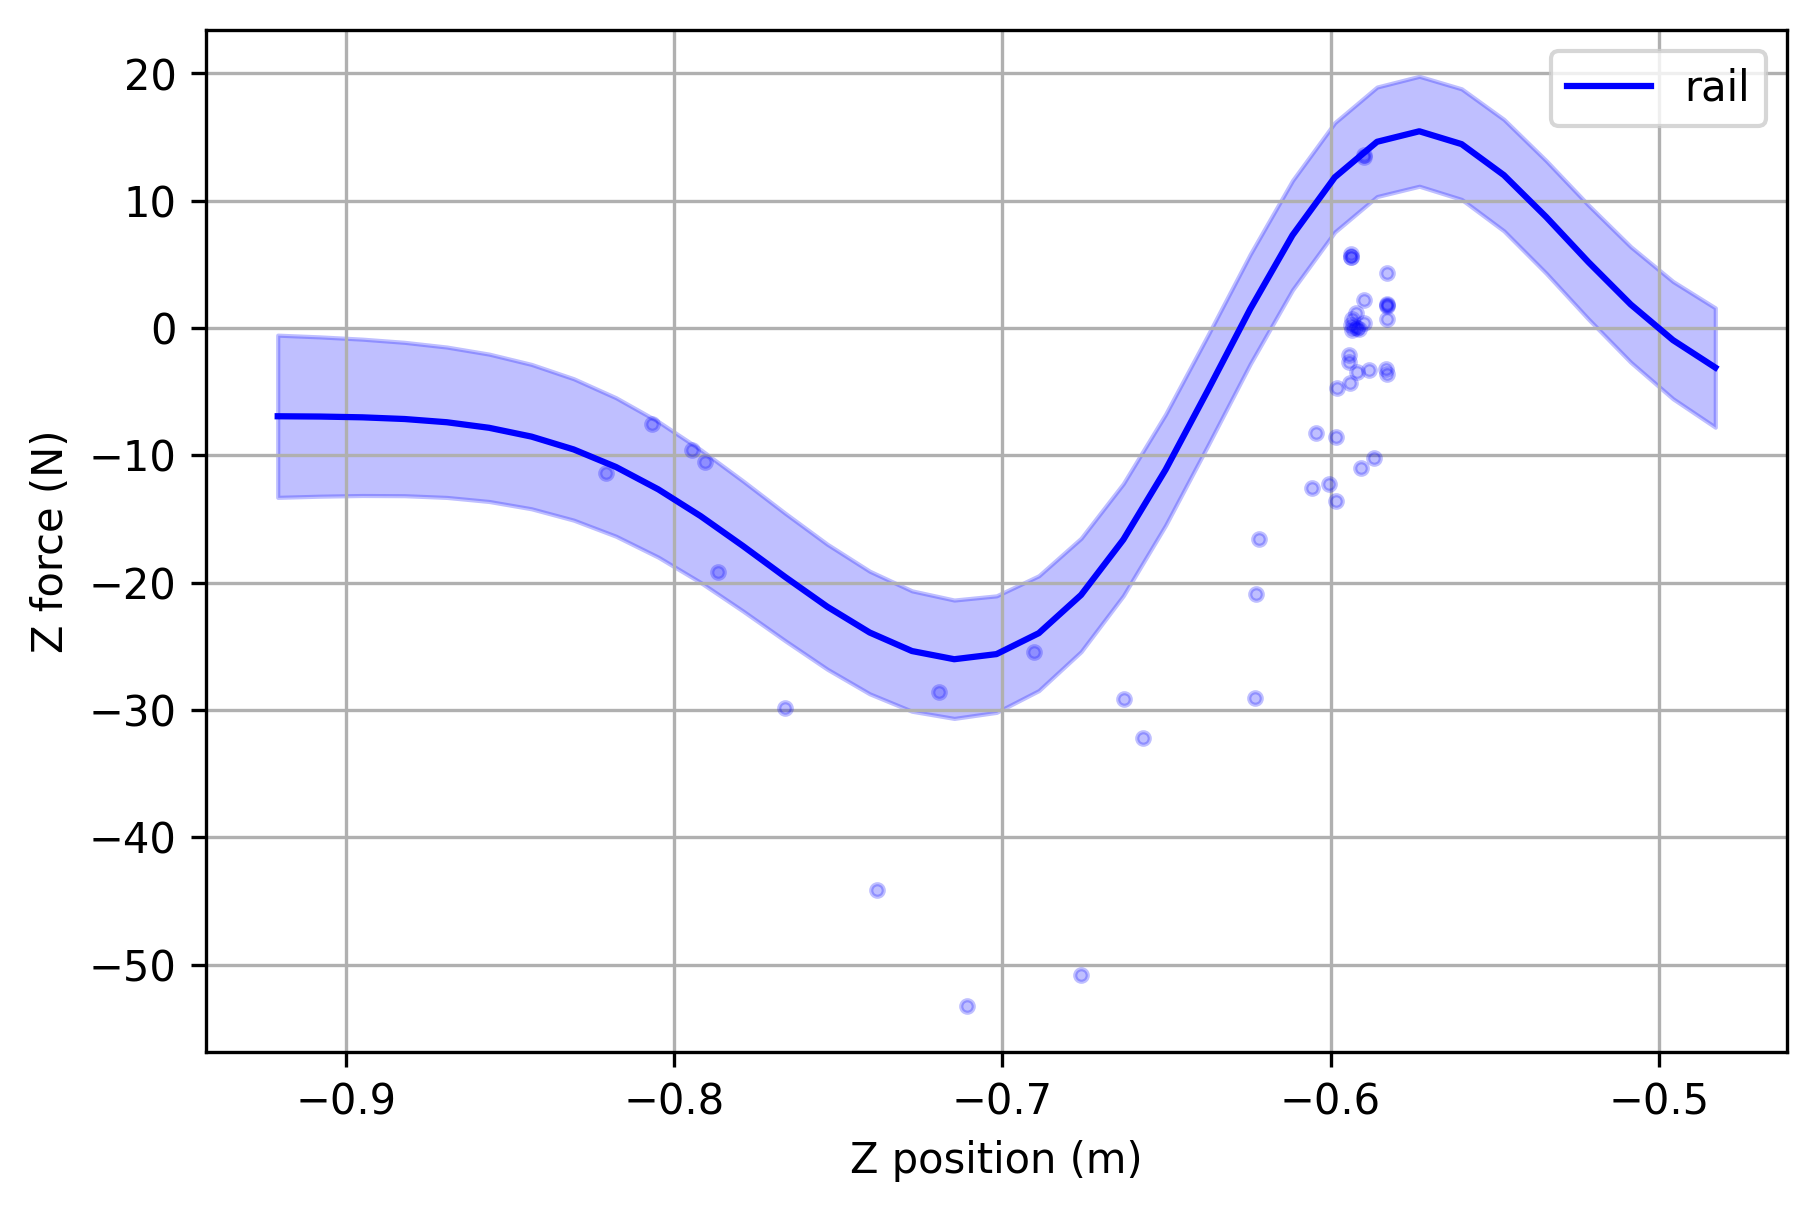

GP Likelihood: [array([-270.3365891]), array([-200.38900298]), array([-293.71595631])]
Stiffness at [0.9474354  0.31447428 0.6320612 ] is -513.746


In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib # Uncomment to unlock the _true_ potential of matplotlib (plot outside browser)

from gp_mpc.gp_wrapper import gp_model
from gp_mpc.helper_fns import *

path = 'data/rail/'  # also data/contact_var/
gp_params = yaml_load(path, 'gp_params.yaml')
gp_params['path'] = path
gp_params['mean_func'] = 'const' # zero, const, linear, hinge. zero and const are tested :) 

# build GP model
gp_models = gp_model(gp_params, rotation = False)
models, modes = gp_models.load_models(rebuild = True) # rebuild = False loads model specified in gp_params['model_path']

# pick our favorite model
model = models[modes[0]]
test_pt = model.get_mean_state() # get test point from middle of GP data
print("Stiffness at {} is {}".format(test_pt, model.grad(test_pt)[2,2]))  # print derivative of Fz w.r.t. z (i.e. vertical stiffness)

### @Christian: we expect that the data/rail/ experiments should have a much lower vertical 
###             stiffness, such as data/contact_var/, which was contact with the metal table. 
###             You should be able to just change the path above to load the two datasets
###             Note that gp_params are loaded from path, so we have a param file per dataset
###             You should be able to change the mean function above

In [45]:
%load_ext autoreload
%autoreload 2
from gp_mpc.helper_fns import *


test_pt_eu = np.array([1.0, 0.05, 0.2, -1.67, 3.09, -1.8])
test_pt = eulerpose_to_rotpose(test_pt_eu)

eu1 = np.array([1.178458767867565, 1.5750399390341376, -3.13720775527019])
eu2 = np.array([1.1800346934408186, 1.5722888936312294, 3.1404767855045317])
print((quat_to_rotvec(euler_to_quat(eu1))))
print((quat_to_rotvec(euler_to_quat(eu2))))
print(rotvec_to_rotation(np.array([1.49708619, 0.99597059, 1.48638353])))
print(euler_to_rotation(np.array([1.1800346934408186, 1.5722888936312294, 3.1404767855045317])))
print(rotvec_to_rotation(np.array([2.5239453,  1.69202554, 2.52206465])))
#%timeit models['polish'].predict(test_pt, [])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.393404
1.16646
[-1.49709, -0.995971, -1.48638]
0.392795
1.16713
[-1.49193, -1.00017, -1.49082]

[[0.00567423, 0.00224456, 0.999981], 
 [0.924002, -0.382363, -0.00438484], 
 [0.382346, 0.92401, -0.0042436]]

[[-0.000463246, 0.924619, 0.380892], 
 [0.00180508, -0.380891, 0.924618], 
 [0.999998, 0.00111587, -0.00149257]]

[[-0.000463247, 0.924619, 0.380892], 
 [0.00180508, -0.380891, 0.924618], 
 [0.999998, 0.00111587, -0.00149256]]


In [4]:
%timeit models['polish'].predict_fast(test_pt)

369 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [4]:
from gp_dynamics import GPDynamics
gpmodel = GPDynamics(N_p = 6, mpc_params = mpc_params, gp = models['polish'])
dyn = gpmodel.MDS_system()
xk = ca.MX.sym('xk',24)
uk = ca.MX.sym('uk',6)
res = dyn(x=xk, u=uk, init_pose=test_pt, hum_kin_opti = [], imp_params = [] )
dyn_map = dyn.map(3)
res_map = dyn_map(x = ca.MX.sym('xk',24,3), u = ca.MX.sym('uk',6,3), hum_kin_opti = [], imp_params = [])
print(dyn_map)
w = []
w += [ca.horzsplit(res_map['xf'])]
print(ca.reshape(res_map['xf'], 24*3,1))

map3_F_int:(x[24x3],u[6x3],init_pose[6x3],hum_kin_opti[],imp_params[12x3])->(xf[24x3],st_cost[1x3],hum_force_cart[6x3],f_cov[1x3],hum_force_joint[]) Map
vec(map3_F_int(xk, uk, zeros(6x3), 0x0, zeros(12x3)){0})


In [5]:
import casadi as ca
q0 = ca.SX.sym('q0', 6)
from helper_fns import *
x = ca.SX.sym('x',6)
quat_to_rotvec(quat_quat_mult(xyz_to_quat(x[3:]), q0))
#xyz_to_quat(x[:3])

SX(@1=2, @2=cos((x_3/@1)), @3=cos((x_4/@1)), @4=cos((x_5/@1)), @5=(@3*@4), @6=sin((x_3/@1)), @7=sin((x_4/@1)), @8=sin((x_5/@1)), @9=(@7*@8), @10=((@2*@5)+(@6*@9)), @11=((@6*@5)-(@2*@9)), @12=(@7*@4), @13=(@3*@8), @14=((@2*@12)+(@6*@13)), @15=((@2*@13)-(@6*@12)), @16=((((@10*q0_0)-(@11*q0_1))-(@14*q0_2))-(@15*q0_3)), @17=sign(@16), @18=acos((@16*@17)), @19=(@1*@18), [(((((((@10*q0_1)+(@11*q0_0))-(@14*q0_3))+(@15*q0_2))*@17)/sin(@18))*@19), (((((((@10*q0_2)+(@11*q0_3))+(@14*q0_0))-(@15*q0_1))*@17)/sin(@18))*@19), (((((((@10*q0_3)-(@11*q0_2))+(@14*q0_1))+(@15*q0_0))*@17)/sin(@18))*@19)])

In [7]:
# Test if hand optimizing XYZ->QUAT brings something. Not much!
import casadi as ca
a = ca.SX.sym('a')
b = ca.SX.sym('b')
c = ca.SX.sym('c')
abc = ca.vertcat(a,b,c)

res1 = ca.sin(a)*ca.sin(b)*ca.sin(c)+ca.cos(a)*ca.cos(b)*ca.cos(c)
res2 = 0.25*(ca.sin(a-b-c)+ca.sin(a+b-c)+ca.sin(a-b+c)-ca.sin(a+b+c)
             +ca.cos(a-b-c)+ca.cos(a+b-c)+ca.cos(a-b+c)+ca.cos(a+b+c))

f1 = ca.Function('f1', [a, b, c], [res1])
jf1 = ca.Function('jf1', [a, b, c], [ca.gradient(res1, abc)])
f2 = ca.Function('f2', [a, b, c], [res2])
jf2 = ca.Function('jf2', [a, b, c], [ca.gradient(res2, abc)])

%timeit f1(0.5, -1.1, 0.3)
%timeit f2(0.5, -1.1, 0.3)

%timeit jf1(0.5, -0.1, 0.3)
%timeit jf2(0.5, -0.1, 0.3)

25.9 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
25.7 µs ± 549 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
24.9 µs ± 220 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
25.8 µs ± 175 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
# Test if rotvec is faster than converting to quat -> not when they become casadi fns!
from src.helper_fns import *
r1 = np.array([0.01, 0.1, 0.05])
r2 = np.array([0.05, 0.2, -0.3])

r1s = ca.SX.sym('r1s',3)
r2s = ca.SX.sym('r2s',3)

print(rotvec_rotvec_mult(r1,r2))
print(quat_to_rotvec(quat_quat_mult(rotvec_to_quat(r1),rotvec_to_quat(r2))))

print(rotvec_vec_mult(r1,r2))
print(quat_vec_mult(rotvec_to_quat(r1),r2))

f1 = ca.Function('f1',[r1s, r2s], [(rotvec_rotvec_mult(r1s,r2s))])
f2 = ca.Function('f2',[r1s, r2s], [(quat_to_rotvec(quat_quat_mult(rotvec_to_quat(r1),rotvec_to_quat(r2))))])

f3 = ca.Function('f3',[r1s, r2s], [(rotvec_vec_mult(r1s,r2s))])
f4 = ca.Function('f4',[r1s, r2s], [(quat_vec_mult(rotvec_to_quat(r1),r2))])

f1j = f1.forward(1)
f2j = f2.forward(1)
f3j = f3.forward(1)
f4j = f4.forward(1)

f1j(r1,r2, f1(r1,r2), 0.1, 0.2)

%timeit f1(r1,r2)
%timeit f2(r1,r2)
%timeit f3(r1,r2)
%timeit f4(r1,r2)

%timeit f1j(r1,r2, f1(r1,r2), 0.1, 0.2)
%timeit f2j(r1,r2, f2(r1,r2), 0.1, 0.2)
%timeit f3j(r1,r2, f3(r1,r2), 0.1, 0.2)
%timeit f4j(r1,r2, f4(r1,r2), 0.1, 0.2)

[0.251992, 1.42378, 0.268161]
[0.0798732, 0.296068, -0.248851]
[0.00979675, 0.204504, -0.300968]
[0.00979675, 0.204504, -0.300968]
133 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
92.1 µs ± 3.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
92.3 µs ± 3.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
78.6 µs ± 8.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
173 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
169 µs ± 6.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
176 µs ± 5.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
167 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
